In [1]:
import sys
sys.path.append('../../../GitHub/')

In [2]:
from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter

In [3]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes   


In [4]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [5]:
def segmenteegdata(eegdata,epochlength,samplingrate):
    epoch = int(epochlength*samplingrate)
    nsamp = np.shape(eegdata)[0]
    nchan = np.shape(eegdata)[1]
    nepoch = int(nsamp/epoch)
    nsamp = nepoch*epoch
    segdata = np.reshape(eegdata[0:nsamp,0:nchan],(nepoch,epoch,nchan))
    return segdata


In [6]:
epoch = 1 #units: seconds
matfile = list()
filedir="../../"
pathname = 'Cleaned_data/'
for file in listdir(filedir+pathname):
	if file.endswith(".mat"):
		matfile.append(file)

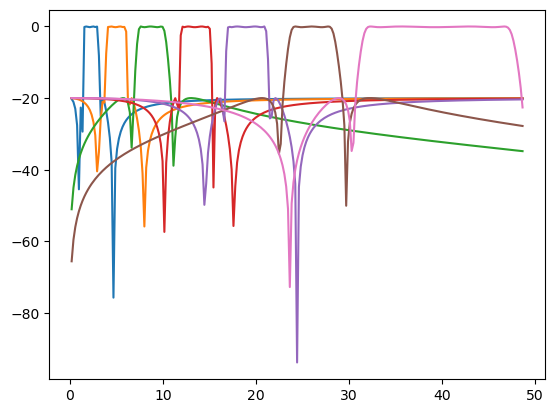

In [7]:
srnew = 200 
downsample = 10 
passbands = [[1.5,3],[4,6],[7.5,10],[12,15],[17 ,21],[24,28],[32,47]]
stopbands = [[1,3.5],[3.5,6.5],[6.5,11],[11,16],[16,22],[22,30],[30,50]]
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    plt.plot(w[1:250],20*np.log10(np.abs(h[1:250])))

In [70]:
filename = matfile[0]
[eeg, intervals, samples, condition_index, session, sr, bpchan, 
   		condition_Names, channels, chan_labels, sessionTypes] \
			= loaddata(filedir+pathname+filename)
#lowpass filter for downsampling
sos_low, w,h = makefiltersos(sr,50,55)
for k in range(12): # for each trial
			#align the length of the two files. 
	nsamp1 = np.shape(eeg[0][k])[0]
	nsamp2 = np.shape(eeg[1][k])[0]
	nsamp = np.min((nsamp1,nsamp2))
	for p in range(2): # for each subject
		trialdata = avref(eeg[p][k][0:nsamp,0:32]) 
		trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
		trialdatanew = trialdata[range(0,nsamp,downsample),:]
		filtdata = dict()
		time = dict()
		hilbertdata = dict()
		empirical_ampcorr = dict()
		phasecorr = dict() #need to to do this still. 
		for f in range(len(passbands)):
			filtdata[f] = sosfiltfilt(esos[f],trialdatanew,axis = 0,padtype ='odd')
			hilbertdata[f] = hilbert(filtdata[f],axis = 0)
			empirical_ampcorr[f] = np.corrcoef(np.transpose(np.abs(hilbertdata[f])))


		

Things to be added now: 
(1) incorporate the analysis of the inverse covariance on the hilbertdata.  Dont forget to remove the mean.  Should be more reasonable to manage now, since there are just 6 bands. 
(2) incorporate the dfa analysis on the envelope time series. (abs of hilbertdata) 
After this are some plots that are useful to visualize things. 
(3) Its going to be more difficult to save all these hilbert outputs of different sizes into one big array.  Do we need to really save it? 
(4) I need to make a phase version of this.  But I am confused. 

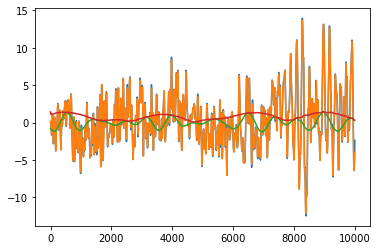

In [61]:
plt.plot(range(10000),trialdata[0:10000,6])
plt.plot(range(0,10000,10),trialdatanew[0:1000,6])
plt.plot(range(0,10000,10),filtdata[0][0:1000,6])
plt.plot(range(0,10000,10),np.abs(hilbertdata[0][0:1000,6]))


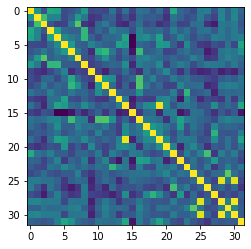

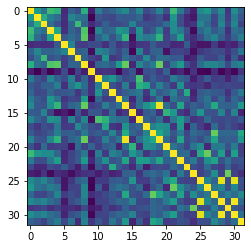

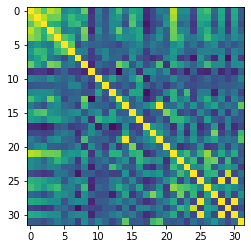

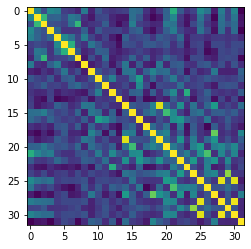

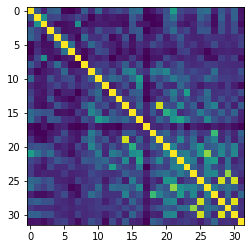

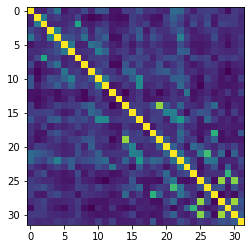

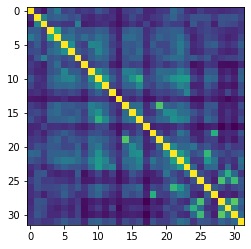

In [71]:
for j in range(len(passbands)):
    plt.figure()
    plt.imshow(ampcorr[j])